# Data preprocessing

The data about the molecules is stored in the database at path `data/trian.db`. It can be accessed through the `ase` library. Each molecule is stored as a row which contains:

- `row.natoms` – number of atoms in the molecule
- `row.symbols` – `np.array` of atom names
- `row.positions` – `np.array` of atom positions in 3d space
- `row.data.energy` – a list with the energy of the molecule

The final data for the neural network will be a table where each row correcponds to a molecule, and each column is the number of each type of bond. To get from a position matrix to a bond type vector the following steps have to be made:
- function to convert a position matrix to distance matrix
- function to convert from the dataset units to real life units (picometers)
- function to convert a distance matrix to bond type matrix
- function to count each bond type

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from ase.db import connect

from tqdm import tqdm

from sklearn.cluster import KMeans

In [2]:
train_db = connect("./data/train.db")

TOTAL_MOLECULES = 138365

## Position matrix to distance matrix

This can be done with multiple for loops, but leveraging the linear algebra knowledge would increase the speed of the code and its simplicity. In this section a feature of numpy will be used called broadcasting. It is when the matricies are not the exact same size however they can be broad casted such that they have the same shape.

In this problems we have 3 dimensions $(x, y, z)$, however for understanding purposes let's imagine that we have only $x$. Let $X$ be a vector of $x$-positions of each molecule

$$ X = 
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_n
\end{bmatrix}.
$$

Now, let's subtract $X^T$ from $X$. Normally we wouldn't be able to do that, however with broadcasting we can, which will yeald us

$$
X - X^T = 
\begin{bmatrix}
x_1    & x_1    & \dots & x_1 \\
x_2    & x_2    & \dots & x_2 \\
\vdots & \vdots & \dots & \vdots \\
x_n    & x_n    & \dots & x_n
\end{bmatrix}
-
\begin{bmatrix}
x_1    & x_2    & \dots & x_n \\
x_1    & x_2    & \dots & x_n \\
\vdots & \vdots & \dots & \vdots \\
x_1    & x_2    & \dots & x_n
\end{bmatrix}
=
\begin{bmatrix}
x_1 - x_1 & x_1 - x_2 & \dots & x_1 - x_n \\
x_2 - x_1 & x_2 - x_2 & \dots & x_2 - x_n \\
\vdots    & \vdots    & \dots & \vdots    \\
x_n - x_1 & x_n - x_2 & \dots & x_n - x_n 
\end{bmatrix},
$$

this is the distance matrix for the $x$-axis. 

Repeating the same for the $Y$ and $Z$ and then taking the normal will give the distance matrix.

$$
\text{norm}(
\begin{bmatrix}
X - X^T & Y - Y^T & Z - Z^T
\end{bmatrix}
\big) = \\
=
\begin{bmatrix}
\sqrt{(x_1 - x_1)^2+(y_1 - y_1)^2+(z_1 - z_1)^2} & \sqrt{(x_1 - x_2)^2+(y_1 - y_2)^2+(z_1 - z_2)^2} & \dots & \sqrt{(x_1 - x_n)^2+(y_1 - y_n)^2+(z_1 - z_n)^2} \\
\sqrt{(x_2 - x_1)^2+(y_2 - y_1)^2+(z_2 - z_1)^2} & \sqrt{(x_2 - x_2)^2+(y_2 - y_2)^2+(z_2 - z_2)^2} & \dots & \sqrt{(x_2 - x_n)^2+(y_2 - y_n)^2+(z_2 - z_n)^2} \\
\vdots    & \vdots    & \dots & \vdots    \\
\sqrt{(x_n - x_1)^2+(y_n - y_1)^2+(z_n - z_1)^2} & \sqrt{(x_n - x_2)^2+(y_n - y_2)^2+(z_n - z_2)^2} & \dots & \sqrt{(x_n - x_n)^2+(y_n - y_n)^2+(z_n - z_n)^2} 
\end{bmatrix}
$$

In [3]:
def position_to_distance_matrix(position_matrix):
    # number of dimensitons (= 3)
    dims = position_matrix.shape[1]

    # expand the shape of the matrix so that they are broadcastable
    m1 = position_matrix.reshape((1, -1, dims))
    m2 = position_matrix.reshape((-1, 1, dims))

    return np.linalg.norm(m1 - m2, axis=-1)
    
position_to_distance_matrix(np.array([
    [0, 0, 0],
    [0, 0, 3],
    [0, 4, 0]
]))

array([[0., 3., 4.],
       [3., 0., 5.],
       [4., 5., 0.]])

Works good.

## Converting units to picometers

The units in the dataset aren't specified. So, we will have to figure out how to convert to them emperically. We'll do that by looking at the distribution of lengths of `C-H` bonds. Since, they can have only one bond, the carbon hydrogen pairs can be divided into two groups one with a bond, and one without.

Based on covalent radii, `C-H` bond has an average length of $R_C + R_H = 31 + 76 = 107$.

In [ ]:
CH_average_bond_length_pm = 31 + 76
CH_bond_lengths = []

for i in tqdm(range(1, TOTAL_MOLECULES+1)):
    row = train_db.get(i)
    symbols = row.symbols
    positions = row.positions

    distance_matrix = position_to_distance_matrix(positions)

    for i, C in enumerate(symbols):
        if C != 'C': continue
        for j, H in enumerate(symbols):
            if H != 'H': continue
            CH_bond_lengths.append(distance_matrix[i][j])
            
CH_bond_lengths = np.array(CH_bond_lengths)
CH_convertion_to_pm = CH_average_bond_length_pm / CH_bond_lengths

Let's cluster the convertion rates using kmeans algorithm with 2 means. If atoms are close, then they are most likely bonded, the bond convertion is the inverse of that, hence we need the bigger number.

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(CH_convertion_to_pm.reshape(-1,1))

mean_converion_rate = max(kmeans.cluster_centers_[:, 0])

mean_converion_rate

In [ ]:
fig, ax = plt.subplots()

ax.hist(CH_convertion_to_pm, bins=100)
ax.scatter(mean_converion_rate, 6e5, marker="*", c='r')

plt.show()

We can see a clear separation between the two groups.

In [ ]:
fig, ax = plt.subplots()

ax.hist(CH_convertion_to_pm, bins=100)
ax.scatter(mean_converion_rate, 6e5, marker="*", c='r')

ax.set_xlim(25, 30)
ax.set_ylim(0, 1e6)

plt.show()

The convertion rate is around $27.15$

In [4]:
CONVERTION_RATE = 27.15

## Is there a bond between atoms?

For each bond there are approximate mean lengths, however, that is not enough to assess whether there is a bond between atoms. A better way to tell is to look at if the bond length is in a certain range. 

Let's figure out all atom pairs there are and look at how distances between them are distributed. It is expected that there would be a division somewhere in the range $[100, 250]$ because that is where the pair-covalent radius sums lie.

In [72]:
# record all atom pair distances

bond_lengths = {}

for i in tqdm(range(1, TOTAL_MOLECULES+1)):
    row = train_db.get(i)
    symbols = row.symbols
    positions = row.positions

    distance_matrix = position_to_distance_matrix(positions)

    for i, a1 in enumerate(symbols):
        for j, a2 in enumerate(symbols):
            if i <= j: continue
                
            bond_name = "".join(sorted([a1, a2]))
            bond_length = distance_matrix[i][j] * CONVERTION_RATE

            if bond_length > 250 or bond_length < 100: continue
            
            if bond_name not in bond_lengths:
                bond_lengths[bond_name] = [bond_length]
            else:
                bond_lengths[bond_name].append(bond_length)

100%|█████████████████████████████████| 138365/138365 [01:50<00:00, 1247.31it/s]


In [73]:
for bond_name in bond_lengths:
    bond_lengths[bond_name] = np.array(bond_lengths[bond_name])

In [74]:
len(bond_lengths)

31

100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 62.98it/s]


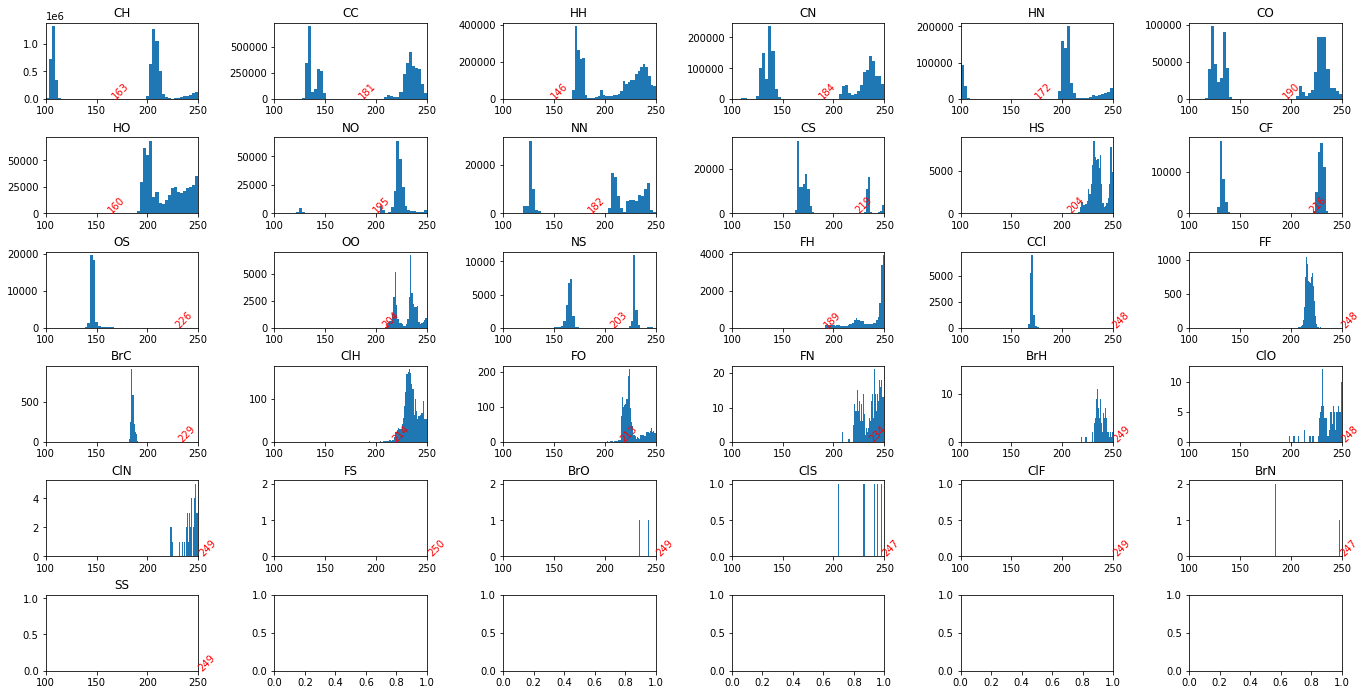

In [75]:
fig, axs = plt.subplots(6, 6, figsize=(20, 10))

for ii, bond_name in enumerate(tqdm(sorted(bond_lengths, key=lambda x: len(bond_lengths[x]), reverse=True))):
    i=ii//6
    j=ii% 6
    ax = axs[i][j]
    ax.set_xlim([100, 250])
    ax.title.set_text(bond_name)
    
    amount, buckets, _ = ax.hist(bond_lengths[bond_name], bins=50)

    zero_x = buckets[np.where(amount <= 5)[0]][-1]
    ax.text(zero_x, np.zeros_like(zero_x), str(round(zero_x)), rotation=45, c='r')
    
plt.subplots_adjust(
    left=0.1,
    bottom=0.1, 
    right=1, 
    top=1, 
    wspace=0.5, 
    hspace=0.5
)

plt.show()

In [249]:
max_bond_length = {
    'CH':163,
    'CC':180,
    'CN':178,
    'HN':150,
    'CO':189,
    'HO':120,
    'NO':180,
    'NN':182,
    'CS':200,
    'CF':210,
    'OS':200,
    'NS':203,
    'CCl':240,
    'BrC':229
}

## Getting the bond type matrix

Now we can try to get the bond type matrix. There are two ways we can achive that:
1. Compare the distance between atoms to the average length of each bond type
2. Make a CSP that assigns the bond types that satisfy the _bond constraint*_

The problem with the first method is that it doesn't account for the bond constraint. The problem with the second method is that there could be multiple ways atoms are bonded and hence we have to choose a csp solution somehow.

To cancel the both problems we will find solutions using a CSP search and if there are multiple solutions then we will look at the one that is the "closest" to the solution from the first method.

\* – bond happends between two atoms when they share electrons. Each atom has a total amount of electrons it can give/take. A bond type is the number of electrons atoms share in a bond.

In [231]:
# get a list of all atoms in the dataset

atoms_in_dataset = set()

for i in tqdm(range(1, TOTAL_MOLECULES + 1)):
    row = train_db.get(i)
    atoms = row.symbols

    atoms_in_dataset.update(atoms)

atoms_in_dataset

  8%|██▋                               | 10784/138365 [00:02<00:28, 4450.38it/s]


KeyboardInterrupt: 

In [243]:
# molecule to test the functions

row = train_db.get(28390)
atom_names = row.symbols
positions = row.positions

distance_matrix = position_to_distance_matrix(positions) * CONVERTION_RATE

### Distance to (possible) bond matrix

For this we will use the maximum bond lengths found earlier. Some atoms are not connected though. That's why it's "possible".

In [244]:
def possibly_is_bond(atom_1, atom_2, bond_length):
    bond_name = "".join(sorted([atom_1, atom_2]))

    if (bond_name in max_bond_length) and (bond_length < max_bond_length[bond_name]):
        return 1
    else:
        return 0

# test the function
possibly_is_bond(atom_names[16], atom_names[20], distance_matrix[16][20])

0

In [245]:
distance_matrix[14][1]

177.9824881432212

Looks good.

In [251]:
def distance_to_possible_bond_matrix(distance_matrix, atoms):
    n_atoms = len(atoms)
    
    bond_matrix = np.zeros_like(distance_matrix)
    
    for i in range(n_atoms-1):
        for j in range(i+1, n_atoms):
            is_bond = possibly_is_bond(atoms[i], atoms[j], distance_matrix[i][j])
            
            bond_matrix[i][j] = is_bond
            bond_matrix[j][i] = is_bond

    return bond_matrix

# test the function
possible_bond_matrix = distance_to_possible_bond_matrix(distance_matrix, atom_names)

# number of possible bonds each atom has
possible_bond_matrix.sum(axis=1)

array([4., 4., 2., 2., 4., 3., 3., 3., 3., 3., 3., 2., 1., 1., 3., 3., 3.,
       3., 3., 2., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

From here errors are already seen. Some atoms have too many bonds...

### Visualize the molecule [bonus]

This is not needed for the problem, however it is useful to be able to inspect the molecule if any errors arise

In [252]:
def str_int(n):
    if type(n) is float or type(n) is int:
        return int(n) if int(n) == n else n
    else:
        return n

def display_molecule_video(row, bond_matrix, atom_text=None, bond_text=None, equal_aspect_ratio=True, angle=10):
    fig = plt.figure()
    fig.set_size_inches(12, 8)

    ax = plt.axes(projection='3d')
    if equal_aspect_ratio:
        p = row.positions
        p_max = p.max()
        p_min = p.min()

        ax.set_xlim([p_min, p_max])
        ax.set_ylim([p_min, p_max])
        ax.set_zlim([p_min, p_max])
    # ax.grid(False)
    
    def init():
        p = row.positions
        s = row.symbols
        n = row.numbers
        
        x = p[:, 0]
        y = p[:, 1]
        z = p[:, 2]

        ax.scatter(x, y, z, 
            s = n*20,        # size
            c = n,           # color
            cmap = 'inferno'
        )
        
        if type(atom_text) != type(None):
            for i in range(len(p)):
                ax.text(x[i], y[i], z[i], str(atom_text[i]))

        for i in range(len(p)):
            for j in range(i+1, len(p)):
                if bond_matrix[i][j] != 0:
                    lx = np.array([x[i], x[j]])
                    ly = np.array([y[i], y[j]])        
                    lz = np.array([z[i], z[j]])

                    ax.plot(lx, ly, lz, color='black')
                    if type(bond_text) != type(None):
                        ax.text(lx.mean(), ly.mean(), lz.mean(), str_int(bond_text[i][j]))
        return fig,


    def animate(i):
        ax.view_init(elev=angle, azim=i)
        return fig,

    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=360, interval=30, blit=True)
    
    plt.close()
    return HTML(anim.to_html5_video())

# test the function
display_molecule_video(
    row, 
    possible_bond_matrix, 
#     atom_text=list(range(row.natoms)),
    atom_text=atom_names, 
    bond_text=None, 
    angle=40
)

## CSP for molecules

In [202]:
from funcs.csp import Problem as CSP
from funcs.csp import ExactSumConstraint, BacktrackingSolver

total_bonds = {
    'Br': 1, 
    'C' : 4, 
    'Cl': 1, 
    'F' : 1, 
    'H' : 1, 
    'N' : 3, 
    'O' : 2, 
    'S' : [2, 4, 6]
}

def get_bond_constraint(total_bonds):
    def bond_constraint(*bonds):
        bond_sum = sum(bonds)

        if type(total_bonds) is list:
            return bond_sum in total_bonds
        else:
            return bond_sum == total_bonds

    return bond_constraint

def sort_tuple(t):
    return tuple(sorted(t))

def csp_solve_bond_matrix(row, bond_matrix, get_bond_names=False, all_sols=True):
    symbols = row.symbols
    n_atoms = row.natoms
    
    variables = []
    bond_names = {}
    
    for i in range(n_atoms-1):
        for j in range(i+1, n_atoms):
            if bond_matrix[i][j]:
                variables.append(sort_tuple((i, j)))
    
    csp = CSP(BacktrackingSolver())
    
    for variable in variables:
        i, j = variable
        a1 = symbols[i]
        a2 = symbols[j]
        bond_name = "".join(sorted([a1, a2]))
        if bond_name not in bond_names:
            bond_names[bond_name] = [variable]
        else:
            bond_names[bond_name].append(variable)
        
        if a1 == 'S':
            number_of_bond_types = min(total_bonds[a1][0], total_bonds[a2])
        elif a2 == 'S':
            number_of_bond_types = min(total_bonds[a1], total_bonds[a2][0])
        else:
            number_of_bond_types = min(total_bonds[a1], total_bonds[a2])
            
        domain = list(range(1, number_of_bond_types+1))
        
        if bond_name == 'CC' or bond_name == 'CN':
            domain = [1, 2, 3, 1.5]
        
        csp.addVariable(variable, domain)

    for i in range(n_atoms):
        a1 = symbols[i]
        bonds = [sort_tuple((i, j)) for j in np.where(bond_matrix[i] > 0)[0]]
        csp.addConstraint(
            get_bond_constraint(total_bonds[a1]),
            bonds
        )
            

    if all_sols:
        solutions = csp.getSolutions()
    else:
        solutions = csp.getSolution()
        if solutions == None:
            solutions = []
        else:
            solutions = [solutions]

    if get_bond_names:
        return bond_names, solutions
    else:
        return solutions

csp_solutions = csp_solve_bond_matrix(row, possible_bond_matrix)

print('Number of solutions:', len(csp_solutions))
# print(csp_solutions)

for sol in csp_solutions:
    print('# of aromatic bonds:', list(sol.values()).count(1.5))

Number of solutions: 3
# of aromatic bonds: 6
# of aromatic bonds: 0
# of aromatic bonds: 0


In [203]:
def get_csp_bond_type_matrix(csp_solution, bond_matrix):
    bond_type_matrix = np.zeros_like(bond_matrix)

    for i, j in csp_solution:
        bond_type_matrix[i][j] = csp_solution[(i, j)]
        bond_type_matrix[j][i] = csp_solution[(i, j)]
        
    return bond_type_matrix

csp_bond_type_matrix = get_csp_bond_type_matrix(csp_solutions[0], possible_bond_matrix)
print(csp_bond_type_matrix)

[[0. 3. 0. ... 0. 0. 0.]
 [3. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [204]:
csp_bond_matrix = (csp_bond_type_matrix != 0).astype('int')

display_molecule_video(
    row, 
    csp_bond_matrix,
    atom_text=atom_names, 
    bond_text=csp_bond_type_matrix, 
    angle=10
)

In [205]:
def csp_solution_to_bond_type_counts(bond_names, solution):
    bond_type_counts = {}
    
    for bond_name in bond_names:
        for var in bond_names[bond_name]:
            if solution[var] > 0:
                bond_type = bond_name + str(solution[var])
                if bond_type in bond_type_counts:
                    bond_type_counts[bond_type] += 1
                else:
                    bond_type_counts[bond_type] = 1
                
    return bond_type_counts

## Processing the whole dataset

Now let's use all the functions to make the dataset

In [221]:
df = pd.DataFrame()
csp_failed_to_solve = []

In [222]:
for i in tqdm(failed):
    row = train_db.get(i)
    atom_names = row.symbols
    positions = row.positions

    distance_matrix = position_to_distance_matrix(positions) * CONVERTION_RATE
    possible_bond_matrix = distance_to_possible_bond_matrix(distance_matrix, atom_names)
    bond_names, csp_solutions = csp_solve_bond_matrix(row, possible_bond_matrix, True, all_sols=False)
    
    if len(csp_solutions) == 0:
        csp_failed_to_solve.append(i)
        continue
    elif len(csp_solutions) == 1:
        csp_solution = csp_solutions[0]
        bond_type_counts = csp_solution_to_bond_type_counts(bond_names, csp_solution)
    else:
        # choose the one with the most aromatic bonds
        csp_solutions.sort(key=lambda sol: list(sol.values()).count(1.5), reverse=True)
        csp_solution = csp_solutions[0]
        bond_type_counts = csp_solution_to_bond_type_counts(bond_names, csp_solution)

    for bond in bond_type_counts:
        if bond not in df.columns:
            df[bond] = 0
        df.loc[i, bond] = bond_type_counts[bond]

100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 131.26it/s]


In [223]:
df.tail()

""


In [224]:
df = df.fillna(0)
df = df.sort_index(axis=1)
df = df.astype('int')

df.to_csv('csp.csv')

df

""


In [42]:
df_ = pd.read_csv('data/processed/csp_full.csv', index_col=0)

In [211]:
df_ = pd.read_csv('data/processed/csp_full.csv', index_col=0)

df_ = pd.concat([df_, df])

df_ = df_.fillna(0)
df_ = df_.sort_index(axis=1)
df_ = df_.sort_index(axis=0)
df_ = df_.astype('int')

# df_.to_csv('data/processed/csp_full.csv')

df_

,BrC1,CC1,CC1.5,CC2,CC3,CCl1,CF1,CH1,CN1,CN1.5,...,CS2,HN1,HO1,NN1,NN2,NO1,NS1,NS2,OS1,OS2
1,0,5,6,1,0,0,0,19,9,0,...,0,1,0,0,0,0,0,0,0,0
2,0,5,6,1,0,0,0,19,9,0,...,0,1,0,0,0,0,0,0,0,0
3,0,5,6,1,0,0,0,19,9,0,...,0,1,0,0,0,0,0,0,0,0
4,0,5,6,1,0,0,0,19,9,0,...,0,1,0,0,0,0,0,0,0,0
5,0,7,0,1,0,0,0,20,9,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138361,0,5,6,1,0,1,0,12,5,0,...,2,1,0,0,1,0,0,0,0,0
138362,0,5,6,1,0,1,0,12,5,0,...,2,1,0,0,1,0,0,0,0,0
138363,0,5,6,1,0,1,0,12,5,0,...,2,1,0,0,1,0,0,0,0,0
138364,0,5,6,1,0,1,0,12,5,0,...,2,1,0,0,1,0,0,0,0,0


In [212]:
failed = np.arange(1, TOTAL_MOLECULES+1)
failed = failed[~np.in1d(failed, df_.index)]
failed = failed.tolist()

failed[:10]

[28390, 33264, 38884, 40602, 52470, 58030, 62525, 63501, 73144, 104153]

In [213]:
len(failed)

12

In [214]:
csp_failed_to_solve

[28390,
 33264,
 38884,
 40602,
 52470,
 58030,
 62525,
 63501,
 73144,
 104153,
 123917,
 127113]